# Bidirectional Recurrent Units

For language modeling, i.e. predicting the next token, it makes sense to condition on the leftward context. However, it also makes sense to look at words from the right to fully understand a sentence. For example, a common task[^1] is to mask out random tokens in a text document and then to train a sequence model to predict the values of the missing tokens. Depending on what comes after the blank, the likely value of the missing token changes dramatically:

```text
I am ___.
I am ___ tired.
I am ___ tired, and I can sleep all day.
```

Clearly the meaning change by reading more into the sentence.
The likely candidates change (e.g. "happy", "not", and "very" ), even when the tokens on the left 
of the blank are the same.

[^1]: Often useful for model pretraining prior to fine-tuning on an actual task of interest.

<br>

## Bidirectional computation

A simple technique transforms any RNN unit (e.g. LSTM, GRU) into a bidirectional unit {cite}`birnn`. 
The input sequence is simply processed in opposing directions. Then, outputs for the same inputs are concatenated for downstream processing. The states are processed independently in the expected order. 

More precisely, let $G$ be a recurrent unit. For $t = 1, \ldots, T$, the forward direction computes:


$$
\boldsymbol{\mathsf{O}}^f_t, \boldsymbol{\mathsf{H}}^f_t = G(\boldsymbol{\mathsf{X}}_t, \boldsymbol{\mathsf{H}}^f_{t-1})
$$

Meanwhile, the backward direction calculates: 

$$
\boldsymbol{\mathsf{O}}^b_{T - t + 1}, \boldsymbol{\mathsf{H}}^b_t = G(\boldsymbol{\mathsf{X}}_{T - t + 1}, \boldsymbol{\mathsf{H}}^b_{t-1})
$$

Finally, the output sequence is given by 

$$(\boldsymbol{\mathsf{O}}^f_t \oplus \boldsymbol{\mathsf{O}}^b_t)_{t=1}^T.$$ 

Note that input indices have to be matched. This is illustrated in {numref}`05-birnn`.

<br>

```{figure} ../../../img/nn/05-birnn.png
---
width: 670px
name: 05-birnn
align: center
---
Building the output vectors (right) in a bidirectional recurrent computation.
```

<br>

## Code implementation

In [1]:
from chapter import *

Creating a **Bidirectional** wrapper unit to convert any to a bidirectional RNN cell:

In [2]:
%%save
from functools import partial


class BiRNN(nn.Module):
    def __init__(self, 
        cell: Type[nn.Module], 
        inputs_dim: int, 
        hidden_dim: int, 
        **kwargs
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.inputs_dim = inputs_dim
        assert hidden_dim % 2 == 0
        self.frnn = cell(inputs_dim, hidden_dim // 2, **kwargs)
        self.brnn = cell(inputs_dim, hidden_dim // 2, **kwargs)
        
    def forward(self, x, state=None):
        state = (None, None) if state is None else state
        fh, bh = state
        fo, fh = self.frnn(x, fh)
        bo, bh = self.brnn(torch.flip(x, [1]), bh)
        bo = torch.flip(bo, [1])
        outs = torch.cat([fo, bo], dim=-1)
        return outs, (fh, bh)


Bidirectional = lambda cell: partial(BiRNN, cell)

from functools import partial


class BiRNN(nn.Module):
    def __init__(self, 
        cell: Type[nn.Module], 
        inputs_dim: int, 
        hidden_dim: int, 
        **kwargs
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.inputs_dim = inputs_dim
        assert hidden_dim % 2 == 0
        self.frnn = cell(inputs_dim, hidden_dim // 2, **kwargs)
        self.brnn = cell(inputs_dim, hidden_dim // 2, **kwargs)
        
    def forward(self, x, state=None):
        state = (None, None) if state is None else state
        fh, bh = state
        fo, fh = self.frnn(x, fh)
        bo, bh = self.brnn(torch.flip(x, [1]), bh)
        bo = torch.flip(bo, [1])
        outs = torch.cat([fo, bo], dim=-1)
        return outs, (fh, bh)


Bidirectional = lambda cell: partial(BiRNN, cell)

**Remark.** For consistency with `LanguageModel`, we expect that the `hidden_dim` parameter is the size of the combined forward and backward outputs. This is so that the linear layer matches the given parameter. In other words, we halve the hidden size of each RNN cell inside the bidirectional model.

Flip function works as follows:

In [3]:
l = [[i, 2 * i] for i in range(6)]
a = torch.tensor(l).reshape(-1, 3, 2)
a

tensor([[[ 0,  0],
         [ 1,  2],
         [ 2,  4]],

        [[ 3,  6],
         [ 4,  8],
         [ 5, 10]]])

Only time dimension is affected by flip:

In [4]:
torch.flip(a, [1])

tensor([[[ 2,  4],
         [ 1,  2],
         [ 0,  0]],

        [[ 5, 10],
         [ 4,  8],
         [ 3,  6]]])

**Shapes.** Recall LSTM has two states. And one state vector for each input sequence:

In [5]:
blstm = Bidirectional(LSTM)(28, 128)
x = torch.randn(32, 30, 28)
outs, (fstate, bstate) = blstm(x)
assert outs.shape == (32, 30, 128)
assert fstate[0].shape == (32, 64), fstate[1].shape == (32, 64)
assert bstate[0].shape == (32, 64), bstate[1].shape == (32, 64)

Our implementation differs a bit with PyTorch where hidden size is doubled:

In [6]:
blstm_torch = nn.LSTM(28, 64, batch_first=True, bidirectional=True)
for net in [blstm, blstm_torch]:
    for name, p in net.named_parameters():
        if "bias" in name:
            p.data.fill_(0.0)
        else:
            p.data.fill_(1.0)

error = torch.abs(blstm(x)[0] - blstm_torch(x)[0]).max()
print(error)
assert error < 1e-5

tensor(2.7418e-06, grad_fn=<MaxBackward1>)


<br>

## Model training

Model training:

In [7]:
import certifi
import ssl
ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=certifi.where())

In [8]:
import keras
import torch
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 32
MAX_WORDS = 20_000      # Only top 20k words
T = 200                 # Only 200 words of each movie review

# Load. Trim or pad sequences to length T
(x_train, y_train), (x_valid, y_valid) = keras.datasets.imdb.load_data(num_words=MAX_WORDS)
x_train = keras.utils.pad_sequences(x_train, maxlen=T)
x_valid = keras.utils.pad_sequences(x_valid, maxlen=T)
print(x_train.shape, x_valid.shape)

train_dataset = TensorDataset(torch.tensor(x_train), torch.tensor(y_train).long())
valid_dataset = TensorDataset(torch.tensor(x_valid), torch.tensor(y_valid).long())
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)    # also sampled

(25000, 200) (25000, 200)


In [9]:
from tqdm.notebook import tqdm

DEVICE = "mps"
LR = 0.001
EPOCHS = 3
MAX_NORM = 1.0
EMBED_DIM = 256
HIDDEN_DIM = 128

train_loss = []
valid_loss = []
valid_accs = []

class LastElement(nn.Module):
    """Get last element of a rank-3 tensor of shape (B, T, h)."""
    def forward(self, x):
        return x[0][:, -1, :]

emb = nn.Embedding(MAX_WORDS, EMBED_DIM)
rnn = Deep(Bidirectional(nn.LSTM))(EMBED_DIM, HIDDEN_DIM, num_layers=3, batch_first=True)
model = nn.Sequential(emb, rnn, LastElement(), nn.Dropout(0.5), nn.Linear(HIDDEN_DIM, 2))
model.to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=LR)

for e in tqdm(range(EPOCHS)):
    for t, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        loss = train_step(model, optim, x, y, MAX_NORM)
        train_loss.append(loss)

        if t % 5 == 0:
            xv, yv = next(iter(valid_loader))
            xv = xv.to(DEVICE)
            yv = yv.to(DEVICE)
            valid_loss.append(valid_step(model, xv, yv))
            valid_accs.append((model(xv).argmax(dim=1) == yv).float().mean().item())

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

**Remark.** *Bidirectional first, then deep.* This allows each layer to benefit from the bidirectional context before passing it to the next layer, i.e. the higher-order states also look at the previous states in two directions. It can be shown that this is consistent with the PyTorch implementation. 

In [10]:
# evaluation (accs)
c = 0
for xv, yv in tqdm(valid_loader):
    xv = xv.to(DEVICE)
    yv = yv.to(DEVICE)
    c += (model(xv).argmax(dim=1) == yv).int().sum().item()

print(c / len(valid_dataset))

  0%|          | 0/782 [00:00<?, ?it/s]

0.87228


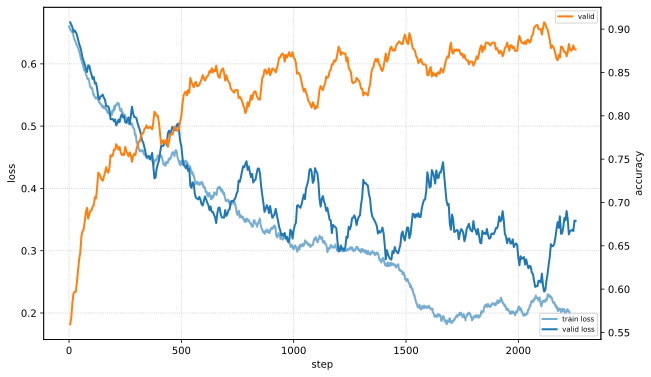

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats("svg")
fig, ax1 = plt.subplots(figsize=(10, 6))

WINDOW_SIZE = 20
train_loss = np.array(train_loss)
valid_loss = np.array(valid_loss)
valid_accs = np.array(valid_accs)
train_loss_avg = [train_loss[i-WINDOW_SIZE * 5:i].mean() for i in range(WINDOW_SIZE * 5, len(train_loss))]
valid_loss_avg = [valid_loss[i-WINDOW_SIZE:i].mean() for i in range(WINDOW_SIZE, len(valid_loss))]
valid_accs_avg = [valid_accs[i-WINDOW_SIZE:i].mean() for i in range(WINDOW_SIZE, len(valid_accs))]

ax1.plot(train_loss_avg, linewidth=2, alpha=0.6, label="train loss", color="C0")
ax1.plot(np.array(range(1, len(valid_loss_avg) + 1)) * 5, valid_loss_avg, linewidth=2, label="valid loss", color="C0")
ax1.set_xlabel("step")
ax1.grid(axis="both", linestyle="dotted", alpha=0.8)

ax2 = ax1.twinx()
ax2.plot(np.array(range(1, len(valid_accs_avg) + 1)) * 5, valid_accs_avg, linewidth=2, label="valid", color="C1")

# ax1.yaxis.label.set_color("C0")
# ax2.yaxis.label.set_color("C1")
ax1.set_ylabel("loss", fontsize=10)
ax2.set_ylabel("accuracy", fontsize=10)
ax1.legend(loc="lower right", fontsize=7)
ax2.legend(loc="upper right", fontsize=7);